<a href="https://colab.research.google.com/github/Berk3459/CRM-Analytics-CLTV-RFM-/blob/main/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# **Exploratory Data Analysis (EDA)**
İlk olarak veri setini inceleyerek başlayalım

In [ ]:
#veri setini yükleme
df = pd.read_csv("/content/file_out.csv.zip")
df.head(5)

,Unnamed: 0,DocumentID,Date,SKU,Price,Discount,Customer,Quantity
0,0,716,2019-09-23,1039,381.78,67.37254,1,1.0
1,1,716,2019-09-23,853,593.22,0.00034,1,1.0
2,2,716,2019-09-23,862,423.73,-0.00119,1,1.0
3,3,716,2019-09-23,868,201.70,35.58814,1,1.0
4,4,716,2019-09-23,2313,345.76,61.01966,1,1.0


In [ ]:
# Gereksiz sütunları kaldırma
df = df.drop("Unnamed: 0",axis = 1)

In [ ]:
# Zaman serisi analizi için tarih indexi oluşturma
df["Date"] = pd.to_datetime(df["Date"])
df.set_index(df["Date"], inplace = True)
df.sort_index(inplace = True)


In [ ]:
# Kolonların isimlerini güncelleme
df.rename(columns = {"DocumentID" : "InvoiceID", "SKU" : "ProductID","Price" : "TotalSales", "Customer" : "CustomerID"},inplace = True)

In [ ]:
df.shape

(33356, 7)

In [ ]:
# Veri setinin son hali
df.head(5)

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,,
2019-01-01,14602,2019-01-01,2647,635.593220,114.406780,211,1.0
2019-01-02,7229,2019-01-02,371,1498.000000,269.640000,512,4.0
2019-01-02,7230,2019-01-02,130,403.889831,72.700169,57,1.0
2019-01-02,3529,2019-01-02,993,621.533898,111.876102,238,1.0
2019-01-02,66,2019-01-02,2775,1100.000000,0.000000,220,2.0


In [ ]:
# veri setindeki sütunların veri tipleri
df.dtypes

,0
InvoiceID,int64
Date,datetime64[ns]
ProductID,int64
TotalSales,float64
Discount,float64
CustomerID,int64
Quantity,float64


In [ ]:
# Eksik veri kontrolü
df.isnull().sum()

,0
InvoiceID,0
Date,0
ProductID,0
TotalSales,0
Discount,0
CustomerID,0
Quantity,0


In [ ]:
# Nümerik değerli sütunlar için özet değerler
df.describe(include = ["float64"])

,TotalSales,Discount,Quantity
count,33356.000000,33356.000000,33356.000000
mean,2915.716875,591.249968,5.760695
std,10285.512325,3508.983569,19.550559
min,0.000000,-0.004920,0.000000
25%,661.016949,95.674576,2.000000
50%,1203.389830,195.254237,4.000000
75%,2572.194915,423.489661,4.000000
max,522767.340000,240396.660000,1246.000000


In [ ]:
# toplam müşteri sayısı
df['CustomerID'].nunique()

606

**Veri Görselleştirme**

In [ ]:
df.head(5)

,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,
2019-01-01,14602,2647,635.593220,114.406780,211,1.0
2019-01-02,7229,371,1498.000000,269.640000,512,4.0
2019-01-02,7230,130,403.889831,72.700169,57,1.0
2019-01-02,3529,993,621.533898,111.876102,238,1.0
2019-01-02,66,2775,1100.000000,0.000000,220,2.0


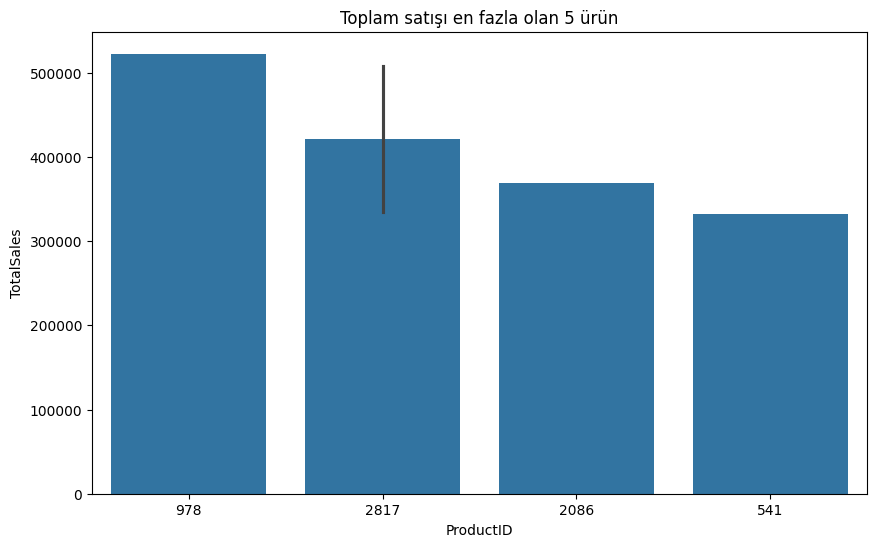

In [ ]:
top_5_sales = df.sort_values(by='TotalSales', ascending=False).reset_index(drop=True).head(5)
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(top_5_sales, x = 'ProductID',y = 'TotalSales',ax=ax)
plt.title("Toplam satışı en fazla olan 5 ürün")
plt.show()


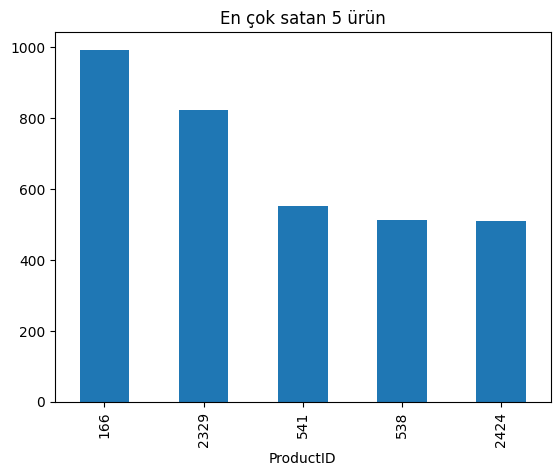

In [ ]:

df['ProductID'].value_counts().iloc[:5].plot(kind="bar",title = "En çok satan 5 ürün")

plt.show()

## RFM Analizi

RFM analizi müşterilerin değerlerini belirli metrikler kullanarak
sınıflandırır ve bu sınıflandırmalardan yola çıkarak müşteri odaklı özel stratejiler geliştirilmesine yardımcı olur.
Bu metrikler şunlardır :
Recency(R) : Yenilik,
Frequency(F) : Sıklık,
Monetary(M) : Parasal Değer

In [ ]:
# Recency değeri için baz alınan tarih
NOW = df.index.max()

In [ ]:
# Öncelikle RFM tablosu oluşturalım
rfmTable = df.groupby('CustomerID').agg({'Date': lambda x: (NOW - x.max()).days,# Recency
                                        'InvoiceID': lambda x: len(x),      # Frequency
                                        'TotalSales': lambda x: x.sum()}) # Monetary Value

rfmTable['Date'] = rfmTable['Date'].astype(int)
rfmTable.rename(columns={'Date':'Recency',
                         'InvoiceID': 'frequency',
                         'TotalSales': 'monetary_value'}, inplace=True)

In [ ]:
quartiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quartiles

,Recency,frequency,monetary_value
0.25,20.0,1.00,1851.694915
0.50,157.5,4.00,8813.559322
0.75,825.0,36.75,76030.683636


In [ ]:
quartiles = quartiles.to_dict()

In [ ]:
rfmSegmentation = rfmTable

In [ ]:
# çeyreklikleri puanlandıralım
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [ ]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency',quartiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

In [ ]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [ ]:
rfmSegmentation['RFMClass'].value_counts()

,count
RFMClass,
111,94
444,53
344,42
243,27
222,26
211,23
434,23
122,22
322,22


In [ ]:
# en iyi 5 müşteri
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('monetary_value', ascending=False).head(5)

,Recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerID,,,,,,,
418,4,608,7.950579e+06,1,1,1,111
359,2,588,4.293243e+06,1,1,1,111
284,0,4227,4.083301e+06,1,1,1,111
286,0,627,3.152595e+06,1,1,1,111
74,11,510,2.735580e+06,1,1,1,111


# Customer Lİfetime Value(CLTV)
Bu kısımda müşterilerin satın alma geçmişlerini inceleyerek bize gelecekte ne kadar kâr getireceğini ,hangi müşterilere daha çok kampanya yapılması gerektiğini ve en çok kâr getiren müşterileri kaybetmemek için neler yapılabileceğini inceleyeceğiz.

In [ ]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.2 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

kuracağımız clv modelinin doğru bir şekilde müşteri segmentasyonu yapabilmesi için aykırı değerleri gidermemiz gerekiyor

In [ ]:
df[['Quantity','TotalSales']].describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,33356.0,5.760695,19.550559,0.0,1.0000,1.000000,2.000000,4.00000,6.000000,18.000000,50.000000,1246.00
TotalSales,33356.0,2915.716875,10285.512325,0.0,111.8175,281.779661,661.016949,1203.38983,3220.338983,9144.914661,26101.697203,522767.34


In [ ]:
# Görüldüğü gibi her iki değişkendede %99luk ve max değerler arasında büyük fark var
# outlier_thresholds fonksiyonu ile aykırı değerler için bir eşik değer belirliyoruz.
# Alt ve Üst sınır olarak bir eşik değer belirliyoruz. Bu aykırı gözlemler eşik değerin dışında kalıyor.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
# replace_with_thresholds fonksiyonunda ise aykırı olan değerleri outlier_thresholds fonksiyonunda saptadığımız eşik değerlerle değiştiriyoruz.
# Yani aykırı değerler artık bizim belirlediğimiz çeyreklikte eşik değerlerle değişmiş oluyor.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "TotalSales")

In [ ]:
df[['Quantity','TotalSales']].describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,33356.0,5.412422,9.022493,0.0,1.0000,1.000000,2.000000,4.00000,6.000000,18.000000,50.000000,125.000000
TotalSales,33356.0,2682.837656,5519.917495,0.0,111.8175,281.779661,661.016949,1203.38983,3220.338983,9144.914661,26101.697203,65254.243008


In [ ]:
rfmSegmentation['avg_order_value'] = rfmSegmentation['monetary_value'] / rfmSegmentation['frequency']

In [ ]:
rfmSegmentation["purchase_frequency"] = rfmSegmentation['frequency'] / rfmSegmentation.shape[0]

In [ ]:
rfmSegmentation['profit_margin'] = rfmSegmentation['monetary_value'] * 0.05

In [ ]:
# Veri setinde en az 1 kere alışveriş yapan müşteri sayısı / tüm müşteri sayısı
repeat_rate = rfmSegmentation[rfmSegmentation.frequency > 1].shape[0] / rfmSegmentation.shape[0]
churn_rate = 1 - repeat_rate

In [ ]:
# Customer Value
rfmSegmentation['cv'] = (rfmSegmentation['avg_order_value'] * rfmSegmentation["purchase_frequency"])


In [ ]:
rfmSegmentation['cltv'] = (rfmSegmentation['cv'] / churn_rate) * rfmSegmentation['profit_margin']

In [ ]:
rfmSegmentation.head()

,Recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,avg_order_value,purchase_frequency,profit_margin,cv,cltv
CustomerID,,,,,,,,,,,,
0,0,19,101061.254237,1,2,1,121,5319.013381,0.031353,5053.062712,166.767746,2.540641e+06
1,599,181,123904.710850,3,1,1,311,684.556414,0.298680,6195.235543,204.463219,3.818999e+06
2,61,35,43406.084743,2,2,2,222,1240.173850,0.057756,2170.304237,71.627203,4.686787e+05
3,10,2,5261.605763,1,3,3,133,2630.802881,0.003300,263.080288,8.682518,6.886690e+03
4,13,111,744094.573008,1,1,1,111,6703.554712,0.183168,37204.728650,1227.878833,1.377305e+08


In [ ]:
# MinMaxScaler
# Bulduğumuz CLTV değerini daha kolay okumak adına 1-100 arası puanlıyoruz.
# cltv_c adında yeni bir değişkene atıyoruz.Calculate edilmiş cltv değerine erişiyoruz.
scaler = MinMaxScaler(feature_range=(1, 100))
scaler.fit(rfmSegmentation[["cltv"]])
rfmSegmentation["cltv_c"] = scaler.transform(rfmSegmentation[["cltv"]])

In [ ]:
# Hesapladığımız müşteri yaşam boyu değerine göre müşterilerimizi segmentlere ayırdık.
rfm_cltv.sort_values(by="cltv_c", ascending=False).head()

# Zaman Serisi Modelleri
**Zaman serisi ayrıştırma**

zaman serisi modeli kurmadan önce veri setini ayrıştırarak daha doğru tahmin modelleri kurabiliriz ve daha doğru kararlar verebiliriz

In [ ]:
# Zaman serisi veri seti
ts = df.groupby('Date')['TotalSales'].sum().to_frame()
ts.head()

,TotalSales
Date,
2019-01-01,635.593220
2019-01-02,27614.008475
2019-01-03,25399.456609
2019-01-04,23814.415086
2019-01-05,15722.511525


In [ ]:
ts.head()

,TotalSales
Date,
2019-01-01,635.593220
2019-01-02,27614.008475
2019-01-03,25399.456609
2019-01-04,23814.415086
2019-01-05,15722.511525


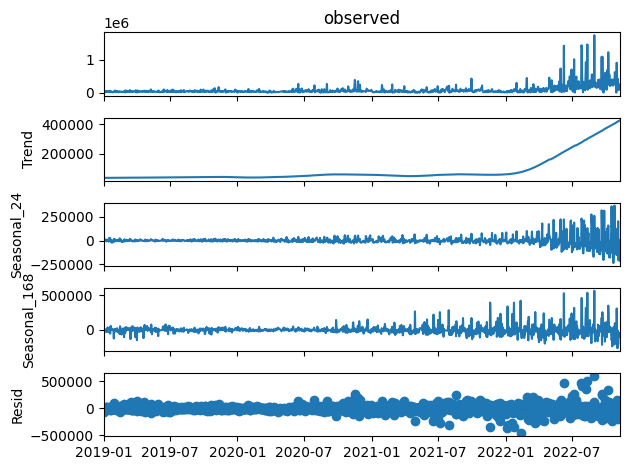

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose,MSTL

res = MSTL(ts, periods=(24, 24*7)).fit()
res.plot()
plt.tight_layout()
plt.show()

Bu sonuçlardan hareketle 2019-2022 yılları arasında satışların durağan trende ilerlediğini ve 2022 yılının başından itibaren trendin pozitif yönde artışa geçtiğini gözlemliyoruz.Ek olarak güünlük ve haftalık mevsimselliğin olduğunu yani satışların belirli bir periyod izlediğini görüyoruz

**Durağanlık testi**
ARIMA gibi modeller için veri setimizin durağan olması gerekir.
AdF testi yardımıyla veri setinin durağan olup olmadığına bakalım

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(ts["TotalSales"])

print(adf_test)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])


(np.float64(0.09835060346869938), np.float64(0.9659483015467684), 23, 1141, {'1%': np.float64(-3.4360941478268767), '5%': np.float64(-2.864076408006588), '10%': np.float64(-2.568120448620112)}, np.float64(29897.86082248247))
ADF Statistic: 0.098351
p-value: 0.965948


p değeri 0.05 den küçük olmadığından h0 hipotezini reddedemeyiz yani verimiz durağan değil. Veri setimizi durağanlaştırmak için diferansiyel alma yöntemini deneyelim.

In [ ]:
ts = ts['TotalSales'].diff().dropna().to_frame()
ts

,TotalSales
Date,
2019-01-02,26978.415255
2019-01-03,-2214.551866
2019-01-04,-1585.041523
2019-01-05,-8091.903561
2019-01-07,36091.301382
...,...
2022-11-04,-203986.416782
2022-11-05,-136380.349488
2022-11-07,171156.083047


In [ ]:
adf_test = adfuller(ts["TotalSales"])

print(adf_test)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

(np.float64(-12.862135447482085), np.float64(5.083932332721321e-24), 23, 1140, {'1%': np.float64(-3.4360991979671205), '5%': np.float64(-2.864078635828568), '10%': np.float64(-2.568121635118498)}, np.float64(29870.200488002833))
ADF Statistic: -12.862135
p-value: 0.000000


görüldüğü gibi p değerimiz 0.05 den küçük çıktı.Yani artık veri setimiz durağan

# ARIMA MODELİ

ARIMA modeli için en iyi parametreleri seçmek için otokorelasyon ve kısmi otokorelasyon grafiklerini inceleyelim.

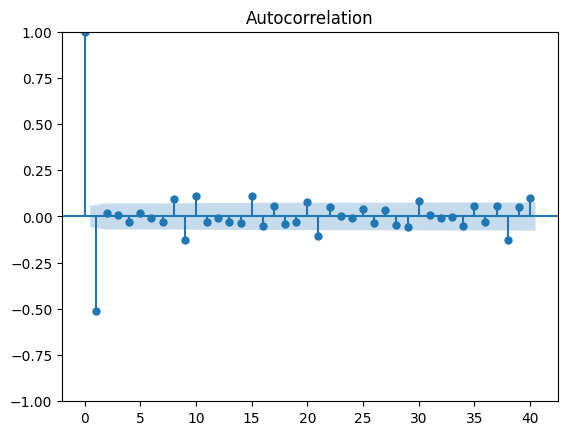

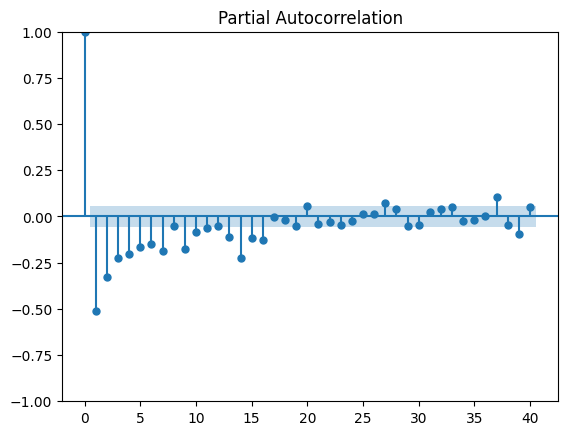

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts['TotalSales'], lags=40)
plot_pacf(ts['TotalSales'], lags=40)
plt.show()

bu grafiklerden yola çıkarak gecikme değerlerini 1 olarak alabiliriz çünkü 1. gecikmelerde önemli sıçramalar görülüyor

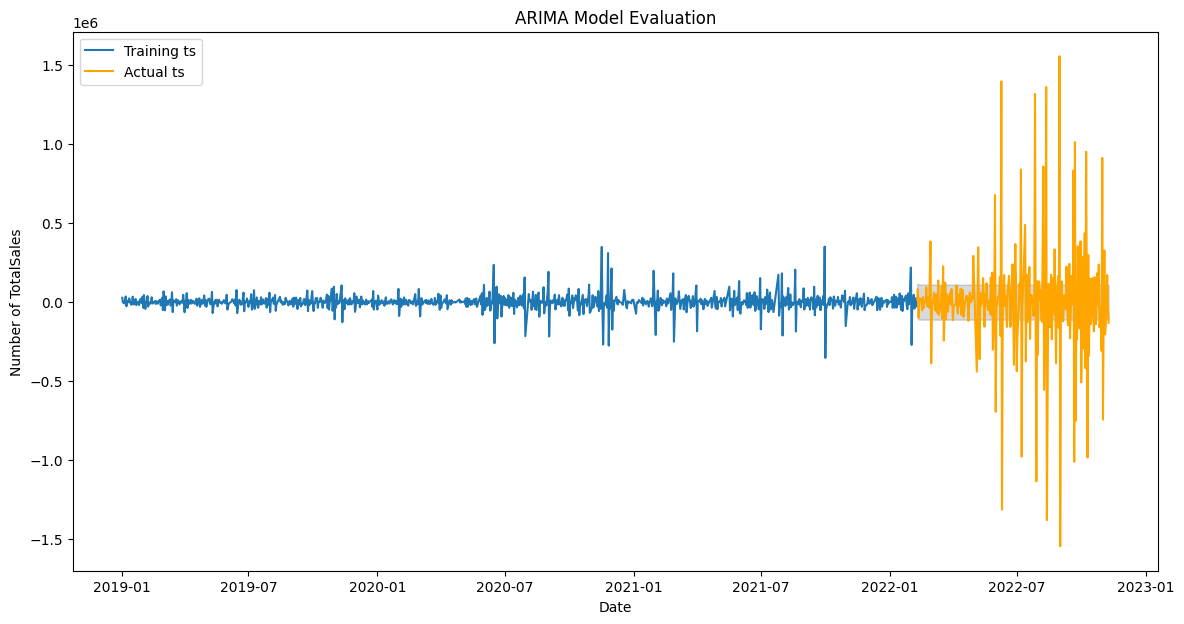

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# veri setini train ve test olarak ayıralım
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:len(ts)]

# ARIMA modelini oluşturalım
model_train = ARIMA(train['TotalSales'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Tahmin değerleri
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)



# grafik çizimi
plt.figure(figsize=(14,7))
plt.plot(train['TotalSales'], label='Training ts')
plt.plot(test['TotalSales'], label='Actual ts', color='orange')

plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of TotalSales')
plt.legend()
plt.show()



**LSTM Model**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import LSTM, Dropout, Dense, Flatten

In [ ]:
ts = df.groupby('Date')['TotalSales'].sum().to_frame()
ts.head()

,TotalSales
Date,
2019-01-01,635.593220
2019-01-02,27614.008475
2019-01-03,25399.456609
2019-01-04,23814.415086
2019-01-05,15722.511525


önce daha doğru sonuçlar almak için verimizi scale edelim

In [ ]:
TotalSales = ts['TotalSales'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(TotalSales)

son 12 aylık verileri kullanarak bir sonraki aydaki toplam satışları tahmin edelim.Önce veri setini train ve test olarak ikiye ayıralım

In [ ]:
window_size = 12
X = []
y = []


for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm modelini kuralım

In [ ]:

def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 128, return_sequences = True, activation="relu", input_shape = (X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = "Adam" , loss = 'mean_absolute_error')
lstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,425 (1.00 MB)

 Trainable params: 263,425 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

kurduğumuz bu modeli eğitelim ve RMSE metriği ile değerlendirelim

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')



Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0131 - val_loss: 0.0157
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0130 - val_loss: 0.0154
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0123 - val_loss: 0.0154
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0122 - val_loss: 0.0153
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0130 - val_loss: 0.0150
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0130 - val_loss: 0.0149
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0126 - val_loss: 0.0153
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

In [ ]:
df[df['CustomerID'] ==284]

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,,
2019-01-02,3538,2019-01-02,1644,237.254237,42.705763,284,1.0
2019-01-03,3555,2019-01-03,701,2457.186441,442.293559,284,4.0
2019-01-03,3554,2019-01-03,1506,2212.372881,398.227119,284,4.0
2019-01-03,3548,2019-01-03,2240,338.974576,61.015424,284,1.0
2019-01-04,4146,2019-01-04,804,1014.627119,182.632881,284,2.0
...,...,...,...,...,...,...,...
2022-11-02,13956,2022-11-02,611,0.000000,0.000000,284,0.0
2022-11-04,15177,2022-11-04,1594,7227.762712,1300.997288,284,4.0
2022-11-04,15173,2022-11-04,1594,3469.322034,624.477966,284,2.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
df_cust = df[df["CustomerID"] == 284]

# Aggregate daily TotalSales
daily_sales = (
    df_cust
    .groupby("Date")["TotalSales"]
    .sum()
    .reset_index()
)

# Keep desired date range
daily_sales = daily_sales[
    (daily_sales["Date"] >= "2019-01-01") &
    (daily_sales["Date"] <= "2020-01-01")
]

daily_sales = daily_sales.set_index("Date")

In [ ]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(daily_sales[["TotalSales"]])


In [ ]:
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW = 30

X, y = create_sequences(scaled_sales, WINDOW)

X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    X, y,
    epochs=30,
    batch_size=16,
    verbose=1
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0119
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0072
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0049
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0127
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0167
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055
Epoch 13/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0172
Epoch 14/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0105
Epoch 15/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0083
Epoc

In [ ]:
future_days = 365

last_window = scaled_sales[-WINDOW:]
predictions = []

current_window = last_window.copy()

for _ in range(future_days):
    current_window_reshaped = current_window.reshape((1, WINDOW, 1))

    next_pred = model.predict(current_window_reshaped, verbose=0)[0, 0]

    predictions.append(next_pred)

    # slide window
    current_window = np.append(current_window[1:], [[next_pred]], axis=0)

# Inverse scale
predictions = scaler.inverse_transform(
    np.array(predictions).reshape(-1, 1)
)


In [ ]:
daily_sales.index = pd.to_datetime(daily_sales.index)


In [ ]:
future_dates = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=future_days
)


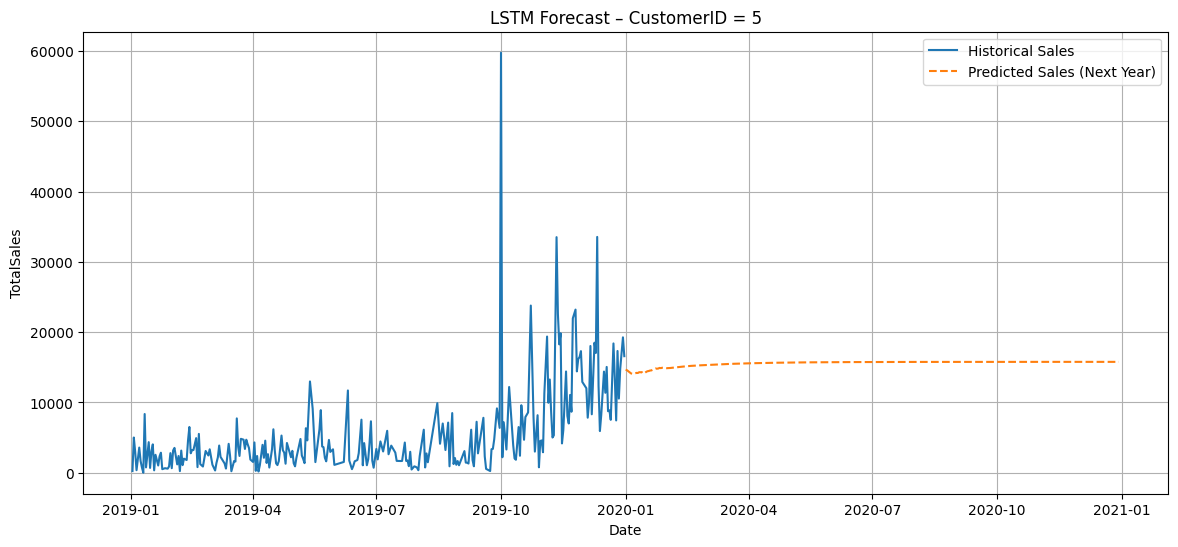

In [ ]:
plt.figure(figsize=(14, 6))

plt.plot(
    daily_sales.index,
    daily_sales["TotalSales"],
    label="Historical Sales"
)

plt.plot(
    future_dates,
    predictions,
    label="Predicted Sales (Next Year)",
    linestyle="--"
)

plt.title("LSTM Forecast – CustomerID = 5")
plt.xlabel("Date")
plt.ylabel("TotalSales")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [ ]:
df = df[df["CustomerID"] == 284]

daily_sales = (
    df.groupby("Date")["TotalSales"]
    .sum()
    .reset_index()
    .set_index("Date")
    .sort_index()
)

daily_sales = daily_sales[
    (daily_sales.index >= "2019-01-01") &
    (daily_sales.index <= "2020-01-01")
]


In [ ]:
def create_lags(df, lags=[1, 7, 14, 30]):
    df_lag = df.copy()
    for lag in lags:
        df_lag[f"lag_{lag}"] = df_lag["TotalSales"].shift(lag)
    return df_lag.dropna()

lags = [1, 7, 14, 30]
data_lagged = create_lags(daily_sales, lags)


In [ ]:
X = data_lagged[[f"lag_{l}" for l in lags]]
y = data_lagged["TotalSales"]


